In [22]:
# Importar las librerías
import importlib
import pandas as pd
import openpyxl

from modules import eventClassifier 
from modules import indexes 
from modules import convertirCSV

importlib.reload(eventClassifier)
importlib.reload(indexes)
importlib.reload(convertirCSV)


<module 'modules.convertirCSV' from '/home/chrisbermudezr/Indices_Climaticos/modules/convertirCSV.py'>

In [ ]:
convertirCSV.dataprocesser('./data/raw')

Procesando archivo: oni.data
Archivo guardado: ./data/oni.csv (líneas descartadas/atípicas: 7)
Procesando archivo: oni.csv
No se encontraron datos válidos en oni.csv


# Carga de las funciones de clasificación   

In [145]:
import numpy as np
import pandas as pd

def MEIClassifier(data, umbral_inferior, umbral_superior):
    """
    Clasifica eventos climáticos (El Niño, La Niña y Neutro) basados en el índice MEI.

    Args:
        data (pd.DataFrame): DataFrame con las columnas 'date' (fechas) y 'value' (índices MEI).
        condicion (int): Número mínimo de meses consecutivos para definir un evento.
        umbral_inferior (float): Umbral inferior para La Niña.
        umbral_superior (float): Umbral superior para El Niño.

    Returns:
        pd.DataFrame: DataFrame con eventos clasificados por fecha y tipo ('Niño', 'Niña', 'Neutro').
    """
    
    data['event'] = data['value'].apply(lambda x: 'Niña' if x <= -0.5 else ('Niño' if x >= 0.5 else 'Neutra'))
    
    data['event'] = data['event'].astype('category')   
     
    return data



def IMTClassifier(x):
   
    # Determinar intensidad (C5, F1, etc.)
    if x >= 4:
        intensidad = 'C5'
    elif 3 <= x < 4:
        intensidad = 'C4'
    elif 2 <= x < 3:
        intensidad = 'C3'
    elif 1 <= x < 2:
        intensidad = 'C2'
    elif 0 <= x < 1:
        intensidad = 'C1'
    elif -1 <= x < 0:
        intensidad = 'F1'
    elif -2 <= x < -1:
        intensidad = 'F2'
    elif -3 <= x < -2:
        intensidad = 'F3'
    elif -4 <= x < -3:
        intensidad = 'F4'
    elif x <= -4:
        intensidad = 'F5'
    else:
        intensidad = 'Desconocido'

    # Mapear intensidad a fase descriptiva
    fase_descripcion = {
        'C5': 'Fase cálida muy fuerte',
        'C4': 'Fase cálida muy fuerte',
        'C3': 'Fase cálida fuerte',
        'C2': 'Fase cálida moderada',
        'C1': 'Fase cálida neutra',
        'F1': 'Fase fría neutra',
        'F2': 'Fase fría moderada',
        'F3': 'Fase fría fuerte',
        'F4': 'Fase fría muy fuerte',
        'F5': 'Fase fría muy fuerte'
    }.get(intensidad, 'Fase desconocida')

    return {
        'intensidad': intensidad,
        'fase': fase_descripcion
    }

def SOIClassifier(data, condicion, umbral_inferior, umbral_superior):
   
   
    anio_inicio = 1951
    anio_fin = data['date'].iloc[-1].year
    final_month = data['date'].iloc[-1].month
    total_meses = pd.date_range(start=f'{anio_inicio}-01-01', end=f'{anio_fin}-{final_month}-01', freq='MS')
    vector_index = np.array(data['value']).flatten()
    vector_index = vector_index[:len(total_meses)]
    
    # Identificar periodos El Niño
    pos_nino = np.where(vector_index <= umbral_inferior)[0]
    D = np.diff(np.concatenate(([0], np.diff(pos_nino) == 1, [0])))
    pos_partida = np.where(D == 1)[0]
    pos_llegada = np.where(D == -1)[0]+1
    posiciones = np.vstack((pos_partida, pos_llegada))
    resultado = np.diff(posiciones, axis=0)
    posiciones_nino = np.where(resultado >= condicion)[1]
    meses_nino = []

    for i in posiciones_nino:
        periodos = pos_nino[pos_partida[i]:pos_llegada[i]]
        meses_nino.extend(total_meses[periodos])
        
    Nino = pd.to_datetime(meses_nino)
    Nino_event = pd.DataFrame({'date': Nino, 'event': 'Niño'})

    # Identificar periodos La Niña
    pos_nina = np.where(vector_index >= umbral_superior)[0]
    D = np.diff(np.concatenate(([0], np.diff(pos_nina) == 1, [0])))
    pos_partida = np.where(D == 1)[0]
    pos_llegada = np.where(D == -1)[0]+1
    posiciones = np.vstack((pos_partida, pos_llegada))
    resultado = np.diff(posiciones, axis=0)
    posiciones_nina = np.where(resultado >= condicion)[1]
    meses_nina = []

    for i in posiciones_nina:
        periodos = pos_nina[pos_partida[i]:pos_llegada[i]]
        meses_nina.extend(total_meses[periodos])
        
    Nina = pd.to_datetime(meses_nina)
    Nina_event = pd.DataFrame({'date': Nina, 'event': 'Niña'})
    
    # Identificar periodos Neutros
    pos_neutro_1 = np.isin(total_meses, Nino)
    pos_neutro_2 = np.isin(total_meses, Nina)
    Neutro = total_meses[~(pos_neutro_1 | pos_neutro_2)]

    Neutro = pd.to_datetime(Neutro)
    
    Neutro_event = pd.DataFrame({'date': Neutro, 'event': 'Neutro'})

    return pd.concat([Nino_event, Nina_event, Neutro_event]).sort_values(by='date').reset_index(drop=True)

def ONIClassifier(data, condicion, umbral_inferior, umbral_superior):
    
    """
    Clasifica eventos climáticos (El Niño, La Niña y Neutro) basados en el índice ONI y los ïndices de las Regiones NIÑO.

    Args:
        data (pd.DataFrame): DataFrame con las columnas 'date' (fechas) y 'value' (índices ONI).
        condicion (int): Número mínimo de meses consecutivos para definir un evento.
        umbral_inferior (float): Umbral inferior para La Niña.
        umbral_superior (float): Umbral superior para El Niño.

    Returns:
        pd.DataFrame: DataFrame con eventos clasificados por fecha y tipo ('Niño', 'Niña', 'Neutro').
    """
   
    anio_inicio = 1950
    anio_fin = data['date'].iloc[-1].year
    final_month = data['date'].iloc[-1].month
    total_meses = pd.date_range(start=f'{anio_inicio}-01-01', end=f'{anio_fin}-{final_month}-01', freq='MS')
    vector_index = np.array(data['value']).flatten()
    vector_index = vector_index[:len(total_meses)]
    
    # Identificar periodos El Niño
    pos_nino = np.where(vector_index >= umbral_superior)[0]
    D = np.diff(np.concatenate(([0], np.diff(pos_nino) == 1, [0])))
    pos_partida = np.where(D == 1)[0]
    pos_llegada = np.where(D == -1)[0]+1
    posiciones = np.vstack((pos_partida, pos_llegada))
    resultado = np.diff(posiciones, axis=0)
    posiciones_nino = np.where(resultado >= condicion)[1]
    meses_nino = []

    for i in posiciones_nino:
        periodos = pos_nino[pos_partida[i]:pos_llegada[i]]
        meses_nino.extend(total_meses[periodos])
        
    Nino = pd.to_datetime(meses_nino)
    Nino_event = pd.DataFrame({'date': Nino, 'event': 'Niño'})

    # Identificar periodos La Niña
    pos_nina = np.where(vector_index <= umbral_inferior)[0]
    D = np.diff(np.concatenate(([0], np.diff(pos_nina) == 1, [0])))
    pos_partida = np.where(D == 1)[0]
    pos_llegada = np.where(D == -1)[0]+1
    posiciones = np.vstack((pos_partida, pos_llegada))
    resultado = np.diff(posiciones, axis=0)
    posiciones_nina = np.where(resultado >= condicion)[1]
    meses_nina = []

    for i in posiciones_nina:
        periodos = pos_nina[pos_partida[i]:pos_llegada[i]]
        meses_nina.extend(total_meses[periodos])
        
    Nina = pd.to_datetime(meses_nina)
    Nina_event = pd.DataFrame({'date': Nina, 'event': 'Niña'})
    
    # Identificar periodos Neutros
    pos_neutro_1 = np.isin(total_meses, Nino)
    pos_neutro_2 = np.isin(total_meses, Nina)
    Neutro = total_meses[~(pos_neutro_1 | pos_neutro_2)]

    Neutro = pd.to_datetime(Neutro)
    
    Neutro_event = pd.DataFrame({'date': Neutro, 'event': 'Neutro'})

    return pd.concat([Nino_event, Nina_event, Neutro_event]).sort_values(by='date').reset_index(drop=True)

def typeClassifier(x):
    
    """
    Clasifica un valor numérico en una categoría basada en rangos.

    Args:
        x (float): El valor numérico a clasificar.

    Returns:
        str: La categoría en la que cae el valor.
    """
    if -0.5 < x < 0.5:
        return 'Neutro'
    elif 0.5 <= x < 1.0 or -1.0 < x <= -0.5:
        return 'Débil'
    elif 1.0 <= x < 1.5 or -1.5 < x <= -1.0:
        return 'Moderado'
    elif 1.5 <= x < 2.0 or -2.0 < x <= -1.5:
        return 'Fuerte'
    else:
        return 'Muy Fuerte'
    
def columnEvaluation(df, col1, col2, nueva_col):

    """
  Evalúa dos columnas en un DataFrame y crea una nueva columna basada en las condiciones especificadas.

  Args:
      df (pd.DataFrame): DataFrame con las columnas a evaluar.
      col1 (str): Nombre de la primera columna a evaluar.
      col2 (str): Nombre de la segunda columna a clasificar.
      nueva_col (str): Nombre de la columna resultante.

  Returns:
      pd.DataFrame: DataFrame con la nueva columna añadida.
  """

    def conditions(row):

        if 'Neutro' in row[col1]:

            return 'Neutro'

        else:

            return typeClassifier(row[col2])


    df[nueva_col] = df.apply(conditions, axis=1)

    return df



# Índice MEI

In [97]:
def meiIndex(df):
    # Transformar el DataFrame
    df_long = df.melt(id_vars=['year'], var_name='month', value_name='value')
    df_long['year'] = df_long['year'].astype(str)
    #initial_line = pd.DataFrame({'year': ['1949'], 'month': ['12'], 'value': [-0.5]})
    #df_long = pd.concat([initial_line, df_long], ignore_index=True)

    df_long['day'] = 1
    df_long['day'] = df_long['day'].astype(str)

    df_long = df_long[df_long['value'] != -99.9]
    df_long['value'] = df_long['value'].round(1)

    df_long['date'] = pd.to_datetime(df_long[['year', 'month', 'day']])
    df_long['date'] = df_long['date'].dt.strftime('%Y-%m-%d')
    df_long = df_long[['date', 'value']]
    df_long = df_long.sort_values(by='date')
    df_long['date'] = pd.to_datetime(df_long['date'])

    df_long['index_name'] = 'MEI'
    df_long['index_description'] = 'Índice Multivariado ENOS: v.2 El índice bimensual Multivariado de El Niño/Oscilación del Sur (ENSO) (MEI.v2) es la serie temporal de la principal Función Ortogonal Empírica (EOF, por sus siglas en inglés) combinada de seis variables diferentes: temperatura superficiel, temperatura del aire, presión atmosférica al nivel del mar, nubosidad, componente zonal del viento y componente meridional del viento en la cuenca del Pacífico tropical (30°S-30°N y 100°E-70°W) (en NOAA/CPC https://www.psl.noaa.gov/enso/mei/).'
    df_long['unit'] = 'dmless'

    # Crear una nueva columna 'Phase' con condiciones basadas en los valores de 'value'
    df_long['phase'] = df_long['value'].apply(lambda x: 'Fría' if x <= -0.5 else ('Cálida' if x >= 0.5 else 'Neutra'))
    
    df_long['phase_description'] = df_long['phase'].apply(lambda x: 'Esta fase se caracteriza por condiciones oceánicas y atmosféricas cálidas asociadas a El Niño (anomalías positivas del MEI)' 
                                                    if x == 'Cálida' else ('Esta fase se caracteriza por condiciones frías asociadas a La Niña (anomalías negativas del MEI)' 
                                                                        if x == 'Fría' else 'Esta fase se caracteriza por condiciones neutrales, sin predominancia de El Niño ni La Niña'))
    # Identificar eventos
    df_long = MEIClassifier (df_long,-0.5, 0.5) # entradas de la función para el evenClassifier

    

    df_long['event_description'] = df_long['event'].apply(lambda x: 'Este evento se caracteriza porque el valor del índice para el mes es igual o inferior al umbral de -0.5' 
                                                    if x == 'Niña' else ('Este evento se caracteriza porque el valor del índice para el mes es igual o supera el umbral de 0.5' 
                                                                         if x == 'Niño' else 'Este evento se caracteriza porque el valor del índice para el mes no supera el umbral de 0.5 y no es inferior al umbral de -0.5'))
    
    df_long['type'] = 'No aplicable'
   

    return df_long

## Carga de los datos

In [98]:
mei_entire_df = pd.read_csv("./data/mei_entire.csv")
mei_entire_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    47 non-null     int64  
 1   01      47 non-null     float64
 2   02      47 non-null     float64
 3   03      47 non-null     float64
 4   04      47 non-null     float64
 5   05      47 non-null     float64
 6   06      46 non-null     float64
 7   07      46 non-null     float64
 8   08      46 non-null     float64
 9   09      46 non-null     float64
 10  10      46 non-null     float64
 11  11      46 non-null     float64
 12  12      46 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 4.9 KB


In [99]:
mei_entire_df

,year,01,02,03,04,05,06,07,08,09,10,11,12
0,1979,0.47,0.29,-0.05,0.21,0.27,-0.11,-0.11,0.47,0.38,0.23,0.53,0.63
1,1980,0.33,0.20,0.39,0.51,0.45,0.55,0.47,0.03,0.12,0.02,-0.07,-0.12
2,1981,-0.36,-0.23,0.33,0.43,-0.24,-0.70,-0.61,-0.34,-0.07,-0.16,-0.27,-0.19
3,1982,-0.43,-0.49,-0.27,-0.36,-0.12,0.62,1.65,1.91,1.69,1.78,2.14,2.37
4,1983,2.48,2.68,2.61,2.76,2.86,1.98,0.63,-0.17,-0.49,-0.53,-0.47,-0.50
5,1984,-0.54,-0.56,-0.16,0.07,-0.45,-0.66,-0.34,-0.20,-0.14,-0.19,-0.58,-0.28
6,1985,-0.25,-0.58,-0.60,-0.76,-1.23,-0.67,-0.10,-0.49,-0.56,-0.08,-0.06,-0.42
7,1986,-0.40,-0.34,-0.40,-0.53,-0.26,0.01,0.41,0.97,1.29,0.56,0.64,1.06
8,1987,1.03,1.16,1.57,1.74,1.96,2.07,1.88,1.46,1.26,1.18,0.90,0.79
9,1988,0.63,0.33,0.17,-0.01,-0.39,-1.17,-1.78,-1.81,-1.80,-1.59,-1.70,-1.55


In [100]:
mei = meiIndex(mei_entire_df)
mei.dropna(subset=['value'], inplace=True)
mei.to_excel("MEI.xlsx", sheet_name="indices", index=False)  # Exporta a Excel
mei  # Muestra el resultado si estás en un notebook o terminal

,date,value,index_name,index_description,unit,phase,phase_description,event,event_description,type
0,1979-01-01,0.5,MEI,Índice Multivariado ENOS: v.2 El índice bimens...,dmless,Cálida,Esta fase se caracteriza por condiciones oceán...,Niño,Este evento se caracteriza porque el valor del...,No aplicable
47,1979-02-01,0.3,MEI,Índice Multivariado ENOS: v.2 El índice bimens...,dmless,Neutra,Esta fase se caracteriza por condiciones neutr...,Neutra,Este evento se caracteriza porque el valor del...,No aplicable
94,1979-03-01,-0.0,MEI,Índice Multivariado ENOS: v.2 El índice bimens...,dmless,Neutra,Esta fase se caracteriza por condiciones neutr...,Neutra,Este evento se caracteriza porque el valor del...,No aplicable
141,1979-04-01,0.2,MEI,Índice Multivariado ENOS: v.2 El índice bimens...,dmless,Neutra,Esta fase se caracteriza por condiciones neutr...,Neutra,Este evento se caracteriza porque el valor del...,No aplicable
188,1979-05-01,0.3,MEI,Índice Multivariado ENOS: v.2 El índice bimens...,dmless,Neutra,Esta fase se caracteriza por condiciones neutr...,Neutra,Este evento se caracteriza porque el valor del...,No aplicable
...,...,...,...,...,...,...,...,...,...,...
46,2025-01-01,-1.0,MEI,Índice Multivariado ENOS: v.2 El índice bimens...,dmless,Fría,Esta fase se caracteriza por condiciones frías...,Niña,Este evento se caracteriza porque el valor del...,No aplicable
93,2025-02-01,-0.8,MEI,Índice Multivariado ENOS: v.2 El índice bimens...,dmless,Fría,Esta fase se caracteriza por condiciones frías...,Niña,Este evento se caracteriza porque el valor del...,No aplicable
140,2025-03-01,-0.7,MEI,Índice Multivariado ENOS: v.2 El índice bimens...,dmless,Fría,Esta fase se caracteriza por condiciones frías...,Niña,Este evento se caracteriza porque el valor del...,No aplicable
187,2025-04-01,-0.4,MEI,Índice Multivariado ENOS: v.2 El índice bimens...,dmless,Neutra,Esta fase se caracteriza por condiciones neutr...,Neutra,Este evento se caracteriza porque el valor del...,No aplicable


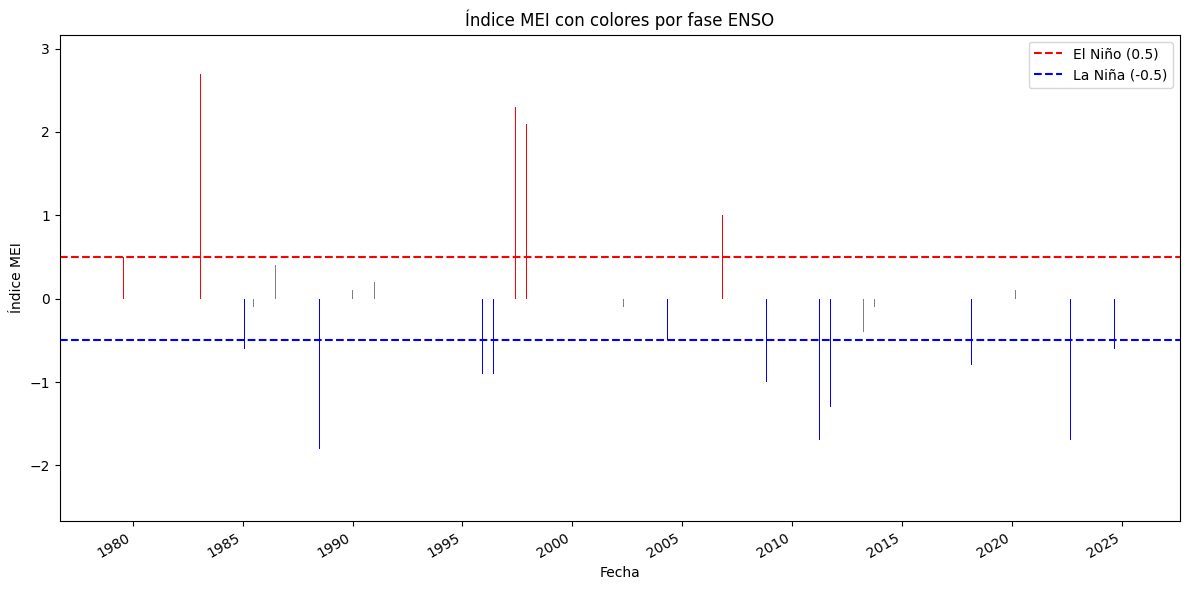

In [101]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

colors = mei['value'].apply(
    lambda x: 'red' if x >= 0.5 else ('blue' if x <= -0.5 else 'gray')
)

# Crear la gráfica
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(mei['date'], mei['value'], color=colors)

# Líneas de referencia
ax.axhline(y=0.5, color='red', linestyle='--', label='El Niño (0.5)')
ax.axhline(y=-0.5, color='blue', linestyle='--', label='La Niña (-0.5)')

# Etiquetas
ax.set_xlabel('Fecha')
ax.set_ylabel('Índice MEI')
ax.set_title('Índice MEI con colores por fase ENSO')
ax.legend()

# Formato de fecha si es necesario
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

# Índice SOI

In [115]:
def soiIndex(df):
    # Transformar el DataFrame
    df_long = df.melt(id_vars=['year'], var_name='month', value_name='value')
    df_long['year'] = df_long['year'].astype(str)
    #initial_line = pd.DataFrame({'year': ['1949'], 'month': ['12'], 'value': [-0.5]})
    #df_long = pd.concat([initial_line, df_long], ignore_index=True)

    df_long['day'] = 1
    df_long['day'] = df_long['day'].astype(str)

    df_long = df_long[df_long['value'] != -99.9]
    df_long['value'] = df_long['value'].round(1)

    df_long['date'] = pd.to_datetime(df_long[['year', 'month', 'day']])
    df_long['date'] = df_long['date'].dt.strftime('%Y-%m-%d')
    df_long = df_long[['date', 'value']]
    df_long = df_long.sort_values(by='date')
    df_long['date'] = pd.to_datetime(df_long['date'])

    df_long['index_description'] = 'Southern Oscillation Index: El Índice de la Oscilación del Sur es un indicador climático que mide la diferencia de presión atmosférica a nivel del mar entre dos estaciones del Pacífico tropical: Tahití (Polinesia Francesa) y Darwin (Australia). Calculada a partir del ERSST V5 (en NOAA/CPC https://www.psl.noaa.gov/data/timeseries/month/DS/SOI/).'
    df_long['unit'] = 'dmLess'

    # Crear una nueva columna 'Phase' con condiciones basadas en los valores de 'value'
    df_long['phase'] = df_long['value'].apply(lambda x: 'Fría' if x > 0 else ('Cálida' if x < 0 else 'Neutra'))
    df_long['phase_description'] = df_long['phase'].apply(lambda x: 'Esta fase se caracteriza por presiones más bajas en Tahití y más altas en Darwin, típicas de El Niño (SOI negativo)' 
                                                    if x == 'Cálida' else ('Esta fase se caracteriza por presiones más altas en Tahití y más bajas en Darwin, típicas de La Niña (SOI positivo)'       
                                                                           if x == 'Fría' else 'Esta fase se caracteriza por condiciones neutrales, sin predominancia de El Niño ni La Niña'))
    # Identificar eventos
    event_total = SOIClassifier (df_long, 5, -0.7, 0.7) # entradas de la función para el evenClassifier

    # Unir los eventos con el DataFrame original
    df_long = pd.merge(df_long, event_total, on='date')

    df_long['event_description'] = df_long['event'].apply(lambda x: 'Este evento se caracteriza porque el valor del índice para el mes es positivo' 
                                                    if x == 'Niña' else ('Este evento se caracteriza porque el valor del índice para el mes es negativo' 
                                                                         if x == 'Niño' else 'Este evento se caracteriza porque el valor del índice para el mes es cero'))
    
    df_long['type'] = 'No aplicable'
   

    return df_long

In [119]:
soi_entire_df = pd.read_csv("./data/soi.csv")
soi_entire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    75 non-null     int64  
 1   01      75 non-null     float64
 2   02      75 non-null     float64
 3   03      75 non-null     float64
 4   04      75 non-null     float64
 5   05      75 non-null     float64
 6   06      74 non-null     float64
 7   07      74 non-null     float64
 8   08      74 non-null     float64
 9   09      74 non-null     float64
 10  10      74 non-null     float64
 11  11      74 non-null     float64
 12  12      74 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 7.7 KB


In [120]:
soi_entire_df

,year,01,02,03,04,05,06,07,08,09,10,11,12
0,1951,2.5,1.5,-0.2,-0.5,-1.1,0.3,-1.7,-0.4,-1.8,-1.6,-1.3,-1.2
1,1952,-1.5,-1.0,0.9,-0.4,1.2,1.2,0.8,0.1,-0.4,0.6,0.0,-2.0
2,1953,0.5,-0.8,-0.3,0.3,-2.8,0.2,0.0,-2.0,-2.1,0.1,-0.5,-0.8
3,1954,1.1,-0.5,0.4,1.1,0.8,0.2,0.7,1.8,0.3,0.4,0.2,2.3
4,1955,-0.9,3.1,1.1,-0.2,1.7,2.2,2.6,2.4,2.2,2.5,2.0,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2021,3.2,2.5,0.6,0.6,0.8,0.7,2.3,1.0,1.3,1.2,1.6,2.5
71,2022,0.8,1.8,2.9,2.8,2.4,2.8,1.3,1.7,2.7,2.8,0.5,3.5
72,2023,2.3,2.3,0.3,0.4,-1.7,0.4,-0.4,-1.4,-2.1,-0.8,-1.3,-0.4
73,2024,0.8,-2.3,0.6,-0.3,0.8,0.1,-1.2,1.5,-0.2,0.8,0.8,1.9


In [121]:
soi = soiIndex(soi_entire_df)
soi.dropna(subset=['value'], inplace=True)
soi.to_excel("SOI.xlsx", sheet_name="indices", index=False)  # Exporta a Excel
soi  # Muestra el resultado si estás en un notebook o terminal

,date,value,index_description,unit,phase,phase_description,event,event_description,type
0,1951-01-01,2.5,Southern Oscillation Index: El Índice de la Os...,dmLess,Fría,Esta fase se caracteriza por presiones más alt...,Neutro,Este evento se caracteriza porque el valor del...,No aplicable
1,1951-02-01,1.5,Southern Oscillation Index: El Índice de la Os...,dmLess,Fría,Esta fase se caracteriza por presiones más alt...,Neutro,Este evento se caracteriza porque el valor del...,No aplicable
2,1951-03-01,-0.2,Southern Oscillation Index: El Índice de la Os...,dmLess,Cálida,Esta fase se caracteriza por presiones más baj...,Neutro,Este evento se caracteriza porque el valor del...,No aplicable
3,1951-04-01,-0.5,Southern Oscillation Index: El Índice de la Os...,dmLess,Cálida,Esta fase se caracteriza por presiones más baj...,Neutro,Este evento se caracteriza porque el valor del...,No aplicable
4,1951-05-01,-1.1,Southern Oscillation Index: El Índice de la Os...,dmLess,Cálida,Esta fase se caracteriza por presiones más baj...,Neutro,Este evento se caracteriza porque el valor del...,No aplicable
...,...,...,...,...,...,...,...,...,...
888,2025-01-01,0.3,Southern Oscillation Index: El Índice de la Os...,dmLess,Fría,Esta fase se caracteriza por presiones más alt...,Neutro,Este evento se caracteriza porque el valor del...,No aplicable
889,2025-02-01,0.9,Southern Oscillation Index: El Índice de la Os...,dmLess,Fría,Esta fase se caracteriza por presiones más alt...,Neutro,Este evento se caracteriza porque el valor del...,No aplicable
890,2025-03-01,2.8,Southern Oscillation Index: El Índice de la Os...,dmLess,Fría,Esta fase se caracteriza por presiones más alt...,Neutro,Este evento se caracteriza porque el valor del...,No aplicable
891,2025-04-01,0.9,Southern Oscillation Index: El Índice de la Os...,dmLess,Fría,Esta fase se caracteriza por presiones más alt...,Neutro,Este evento se caracteriza porque el valor del...,No aplicable


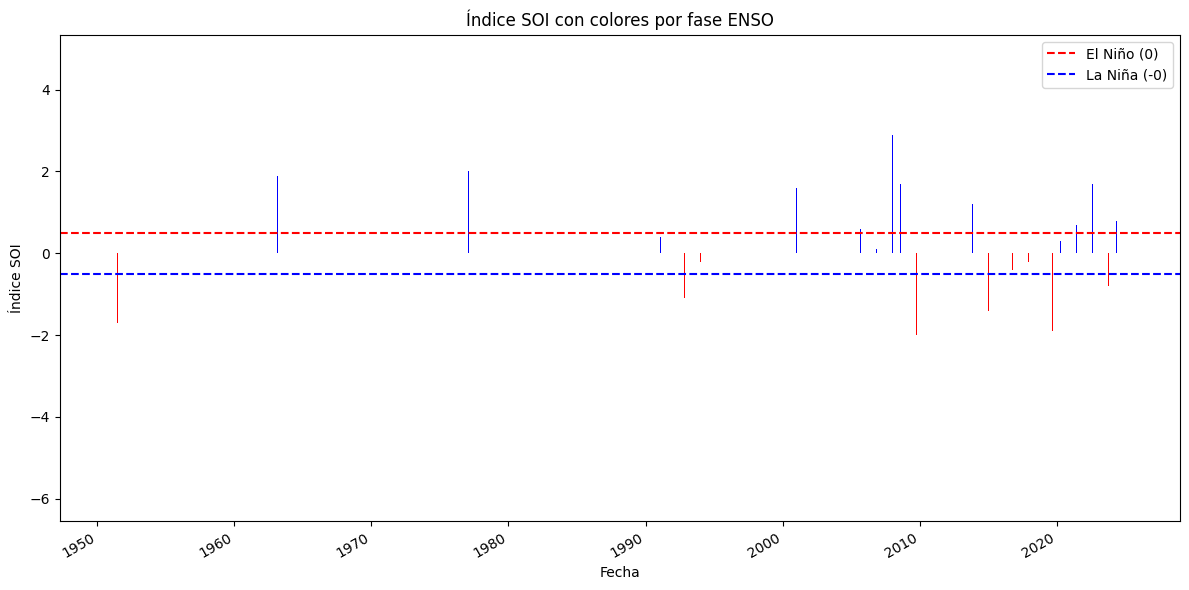

In [ ]:
colors = soi['value'].apply(
    lambda x: 'red' if x < 0 else ('blue' if x > 0 else 'gray')
)

# Crear la gráfica
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(soi['date'], soi['value'], color=colors)

# Líneas de referencia
ax.axhline(y=0.5, color='red', linestyle='--', label='El Niño (0.7)')
ax.axhline(y=-0.5, color='blue', linestyle='--', label='La Niña (-0)')

# Etiquetas
ax.set_xlabel('Fecha')
ax.set_ylabel('Índice SOI')
ax.set_title('Índice SOI con colores por fase ENSO')
ax.legend()

# Formato de fecha si es necesario
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

# Índice IMT

In [146]:
def imtIndex(df):
    # Transformar el DataFrame
    df_long = df.melt(id_vars=['year'], var_name='month', value_name='value')
    df_long['year'] = df_long['year'].astype(str)
    #initial_line = pd.DataFrame({'year': ['1949'], 'month': ['12'], 'value': [-0.5]})
    #df_long = pd.concat([initial_line, df_long], ignore_index=True)

    df_long['day'] = 1
    df_long['day'] = df_long['day'].astype(str)

    df_long = df_long[df_long['value'] != -99.9]
    df_long['value'] = df_long['value'].round(1)

    df_long['date'] = pd.to_datetime(df_long[['year', 'month', 'day']])
    df_long['date'] = df_long['date'].dt.strftime('%Y-%m-%d')
    df_long = df_long[['date', 'value']]
    df_long = df_long.sort_values(by='date')
    df_long['date'] = pd.to_datetime(df_long['date'])

    df_long['index_name'] = 'IMT'
    df_long['index_description'] = 'El Índice Multivariado de Tumaco (IMT) es un indicador climático utilizado para monitorear las condiciones oceánicas y atmosféricas en la región del Pacífico colombiano, específicamente en la ensenada de Tumaco. Este índice integra múltiples variables meteorológicas y oceanográficas para evaluar fenómenos como El Niño y La Niña, así como condiciones neutras en la zona. (en DIMAR/CCCP https://cccp.dimar.mil.co/IMT).'
    df_long['unit'] = 'dmless'

    # Crear una nueva columna 'Phase' con condiciones basadas en los valores de 'value'
    
    df_long[['phase', 'phase_description']] = df_long['value'].apply(lambda x: pd.Series(IMTClassifier(x)))
    
    
    
    
    df_long['type'] = 'No aplicable'
   

    return df_long

In [147]:
imt_entire_df = pd.read_csv("./data/IMT.csv")
imt_entire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    65 non-null     int64  
 1   1       65 non-null     float64
 2   2       65 non-null     float64
 3   3       65 non-null     float64
 4   4       65 non-null     float64
 5   5       65 non-null     float64
 6   6       64 non-null     float64
 7   7       64 non-null     float64
 8   8       64 non-null     float64
 9   9       64 non-null     float64
 10  10      64 non-null     float64
 11  11      64 non-null     float64
 12  12      64 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 6.7 KB


In [148]:
imt_entire_df

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,1961,-0.5503,-0.6500,-0.7840,-0.7795,-0.7798,-0.8919,-0.4463,-0.0187,0.1797,-0.2650,-0.3416,0.0604
1,1962,-0.0904,-0.4038,-1.1766,-1.3055,-1.3464,-1.0951,-0.6193,0.0352,-0.0041,-0.2593,-0.8575,-0.7802
2,1963,-0.5773,-0.4871,-0.8910,-1.6072,-1.9464,-1.6167,-0.9973,-0.5845,-0.2291,0.0585,0.2961,0.5045
3,1964,0.2932,0.4010,-0.3358,-0.9891,-2.0549,-1.7116,-1.4464,-0.9118,-1.2347,-1.1839,-1.4731,-1.6707
4,1965,-1.1551,-0.5105,-0.5244,-0.8208,-0.7637,0.1461,0.5215,0.6767,0.8184,1.1567,1.6610,1.8870
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2021,-0.7442,-0.2607,-0.3059,-0.5339,-0.4218,-0.2148,-0.1456,-0.0643,-0.5258,-1.0304,-1.6687,-1.7402
61,2022,-1.8023,-1.1610,-0.7906,-0.3623,-0.8157,-1.1796,-1.3209,-1.3558,-1.6718,-2.1480,-2.2614,-1.6841
62,2023,-1.3181,-0.8054,-0.2842,1.6226,2.4031,3.4469,2.9093,3.3466,3.1952,3.4864,3.1999,2.9615
63,2024,2.3697,1.7607,1.0102,0.7689,0.7267,0.6415,0.1662,0.3709,0.4482,0.4758,0.0169,0.3901


In [149]:
imt = imtIndex(imt_entire_df)
imt.dropna(subset=['value'], inplace=True)
imt.to_excel("IMT.xlsx", sheet_name="indices", index=False)  # Exporta a Excel
imt  # Muestra el resultado si estás en un notebook o terminal

,date,value,index_name,index_description,unit,phase,phase_description,type
0,1961-01-01,-0.6,IMT,El Índice Multivariado de Tumaco (IMT) es un i...,dmless,F1,Fase fría neutra,No aplicable
65,1961-02-01,-0.6,IMT,El Índice Multivariado de Tumaco (IMT) es un i...,dmless,F1,Fase fría neutra,No aplicable
130,1961-03-01,-0.8,IMT,El Índice Multivariado de Tumaco (IMT) es un i...,dmless,F1,Fase fría neutra,No aplicable
195,1961-04-01,-0.8,IMT,El Índice Multivariado de Tumaco (IMT) es un i...,dmless,F1,Fase fría neutra,No aplicable
260,1961-05-01,-0.8,IMT,El Índice Multivariado de Tumaco (IMT) es un i...,dmless,F1,Fase fría neutra,No aplicable
...,...,...,...,...,...,...,...,...
64,2025-01-01,0.7,IMT,El Índice Multivariado de Tumaco (IMT) es un i...,dmless,C1,Fase cálida neutra,No aplicable
129,2025-02-01,1.5,IMT,El Índice Multivariado de Tumaco (IMT) es un i...,dmless,C2,Fase cálida moderada,No aplicable
194,2025-03-01,1.9,IMT,El Índice Multivariado de Tumaco (IMT) es un i...,dmless,C2,Fase cálida moderada,No aplicable
259,2025-04-01,1.6,IMT,El Índice Multivariado de Tumaco (IMT) es un i...,dmless,C2,Fase cálida moderada,No aplicable


Procesando archivo: oni.data
No se encontraron datos válidos en oni.data
